In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.regression import *

### pycaret 설치 가이드 (Python 3.8 기준)

1. pip install pycaret==3.1.0

2. pip install joblib==1.3

In [2]:
dg_df = pd.read_csv('./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/Demographics.csv')
dg_df.head(16)

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


In [3]:
df = pd.read_csv(r'./features.csv', sep='\t', encoding='utf-8')

In [4]:
df = df.dropna().drop(columns=['Unnamed: 0']).reset_index(drop=True)

In [5]:
df.isna().sum()

calories2hr       0
protein2hr        0
sugar2hr          0
carbs2hr          0
calories8hr       0
                 ..
ID                0
HbA1c             0
Biological Sex    0
WakeTime          0
label             0
Length: 72, dtype: int64

In [6]:
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})

In [7]:
df['label'] = df['label'].map({'PersLow': 0, 'PersNorm': 1, 'PersHigh':2})

### 상관관계 Matrix Heat map

In [8]:
corrdf = df.drop(columns=['datetime']).corr()

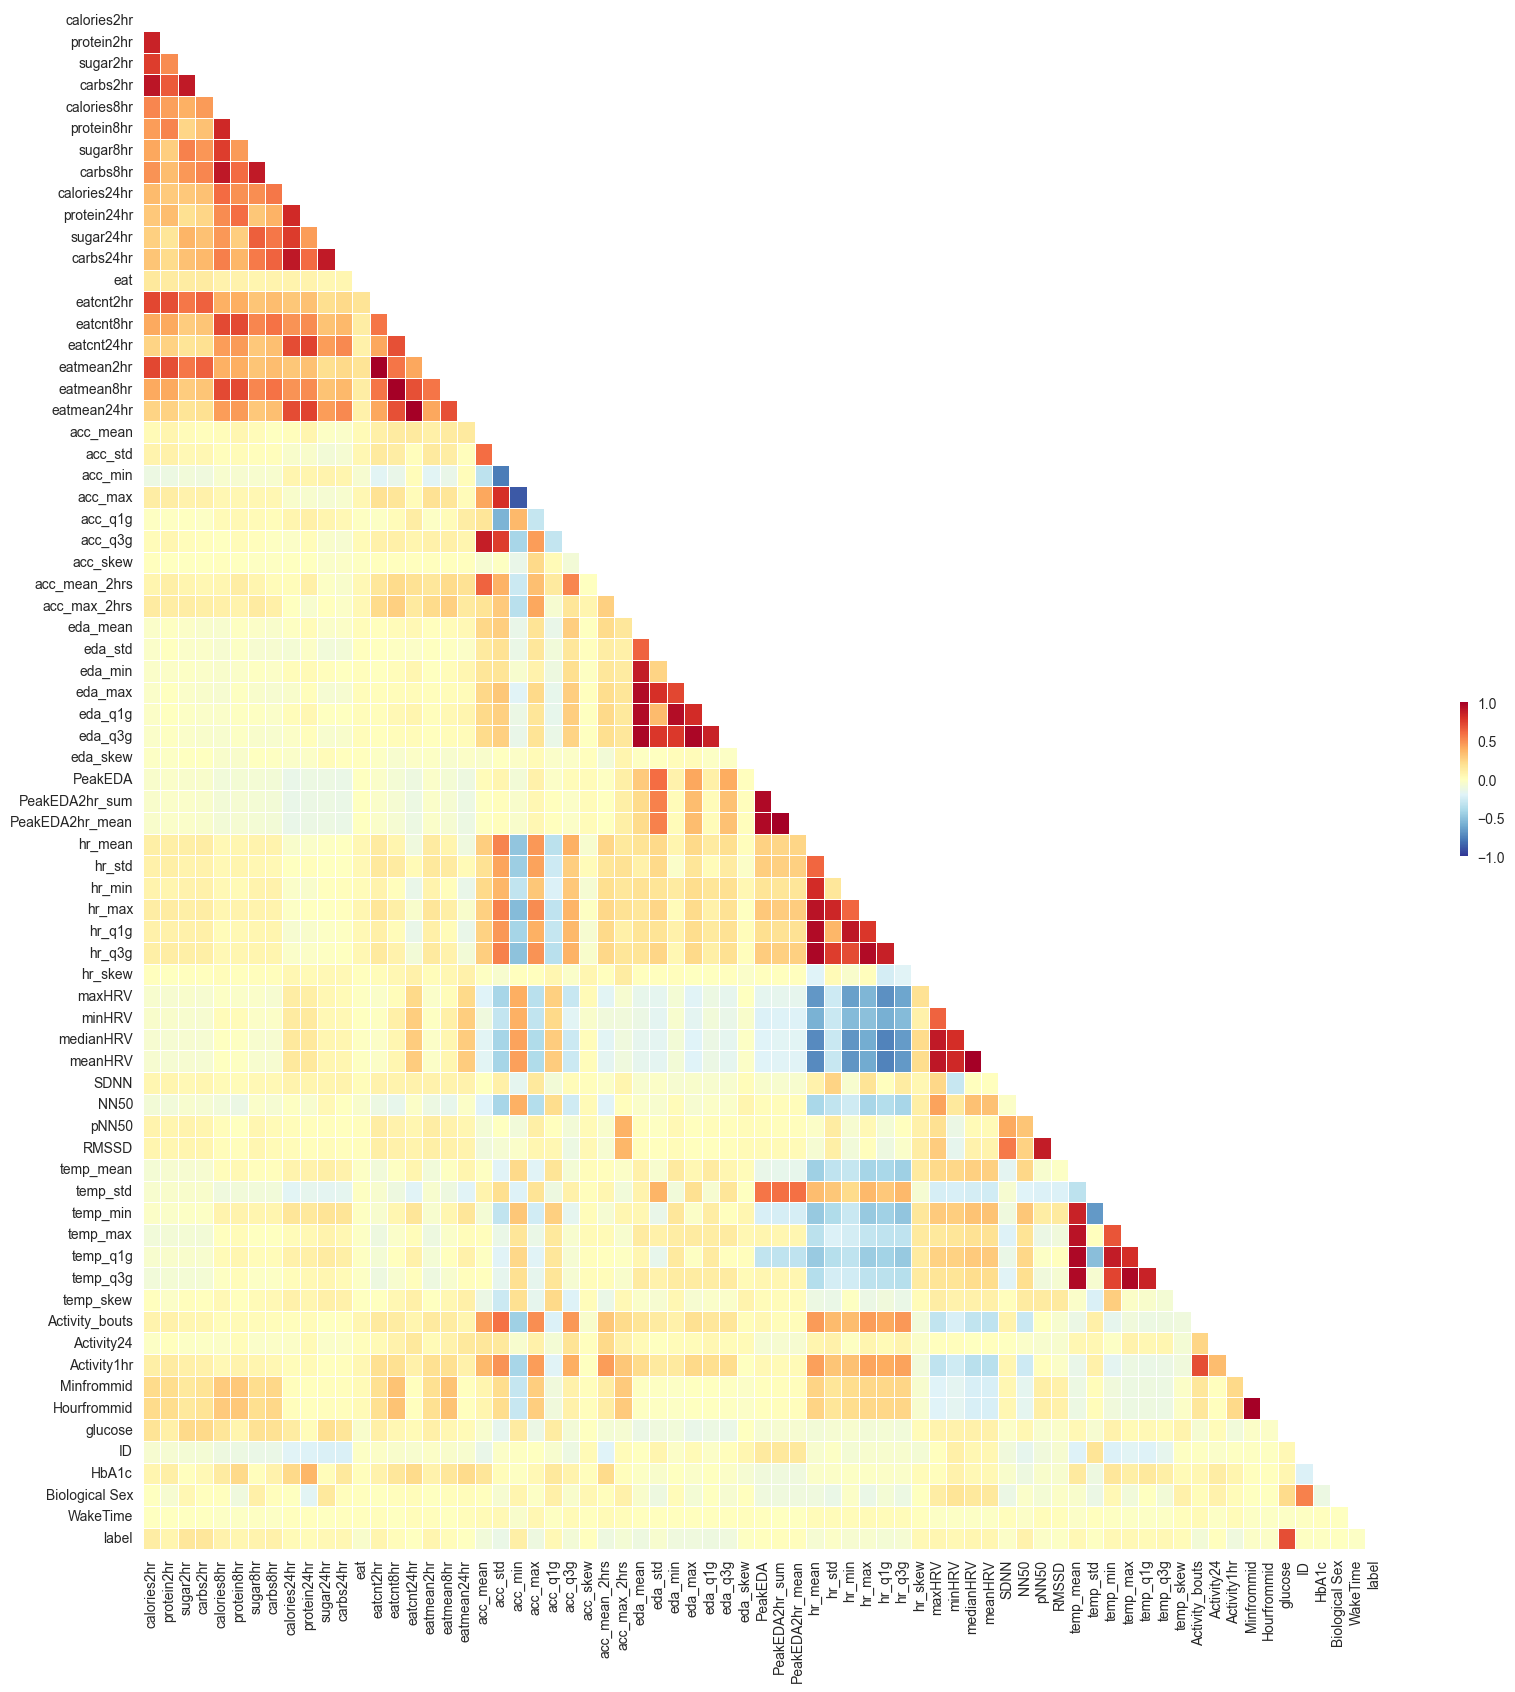

In [9]:
import seaborn as sns

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(20,20) )

mask = np.zeros_like(corrdf)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(corrdf, 
            cmap = 'RdYlBu_r', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .1},# 컬러바 크기 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

### Leave-one-person-out cross validation : 최적의 MSE 평균을 내는 모델을 이용한 간질 포도당 예측

def ModelCompareLOOCV(data, ids, outcomevar, dropcols, idcolumn):
    LOOCV_O = str(ids)
    data[idcolumn] = data[idcolumn].apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')
   
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    ## PYCARET
    exp = setup(data_train, test_data = data_test, target='glucose')
    comp = compare_models()

    return comp

def loocvLGBMRegressor(data, idcolumn, outcomevar, dropcols=[], numestimators=1000):
    # Make list of all ID's in idcolumn
    IDlist = list(set(data[idcolumn].astype(str))) # list(data[idcolumn]) -> list(set(data[idcolumn]))
    print(f'IDlist : {IDlist}')
    drop = [idcolumn]
    drop = drop + dropcols
    
    # Initialize empty lists and dataframe 
    errors = []
    rmse = []
    mape = []
    
    for i in IDlist:
        comp = ModelCompareLOOCV(data, i, outcomevar, drop, idcolumn, numestimators)
        #TODO : comp로부터 각 모델 별 MAPE, MSE를 저장

        idt = str(i)
        print('...' + idt + ' processing complete.')

    #TODO : 위의 for문에서 저장한 각 모델 별 MAPE, MSE의 평균을 계산
    
    
    #TODO : RMSE의 평균이 가장 낮은 모델을 출력하기

    return 

In [10]:
import numpy as np
import pandas as pd
from pycaret.regression import setup, compare_models, predict_model

def ModelCompareLOOCV(data, ids, outcomevar, dropcols, idcolumn):
    LOOCV_O = str(ids)
    data[idcolumn] = data[idcolumn].apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')
   
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    ## PYCARET
    exp = setup(data_train, 
                test_data=data_test, 
                target=outcomevar, 
                feature_selection = True,
                feature_selection_method = 'classic', # or 'boruta' 
                #feature_selection_estimator= ''
                verbose=False, 
                session_id = 123, #random state
                use_gpu = False)
    comp = compare_models(cross_validation=False, n_select=20, verbose=True)#, errors = 'raise')

    return comp, exp, data_test, y_test

def loocvModelCompareRegressor(data, idcolumn, outcomevar, dropcols=[]):
    # Make list of all ID's in idcolumn
    IDlist = list(set(data[idcolumn].astype(str))) # list(data[idcolumn]) -> list(set(data[idcolumn]))
    print(f'IDlist : {IDlist}')
    drop = [idcolumn]
    drop = drop + dropcols
    
    # Initialize empty lists and dataframe 
    model_errors = {}

    for i in IDlist:
        comp, exp, data_test, y_test = ModelCompareLOOCV(data, i, outcomevar, drop, idcolumn)
        #print(comp)
        
        for model in comp:
            model_name = model.__class__.__name__
            if model_name not in model_errors:
                model_errors[model_name] = {'MAPE': [], 'MSE': [], 'RMSE': []}
            
            # Predict on the test set
            predictions = predict_model(model, data=data_test, verbose=False)
            #print(predictions)
            y_pred = predictions['glucose']
            
            # Calculate errors
            mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
            mse = np.mean((y_test - y_pred) ** 2)
            rmse = np.sqrt(mse)
            
            # Store errors
            model_errors[model_name]['MAPE'].append(mape)
            model_errors[model_name]['MSE'].append(mse)
            model_errors[model_name]['RMSE'].append(rmse)
        #idt = str(i)
        #print('...' + idt + ' processing complete.')

    # Calculate the average MAPE, MSE, and RMSE for each model
    model_avg_errors = {model: {metric: np.mean(values) for metric, values in metrics.items()} for model, metrics in model_errors.items()}
    
    # Find the model with the lowest average RMSE
    #best_model = min(model_avg_errors, key=lambda model: model_avg_errors[model]['RMSE'])
    #best_model_errors = model_avg_errors[best_model]

    #print(f'Best model: {best_model}')
    #print(f'Errors: {best_model_errors}')

    #return best_model, best_model_errors


In [11]:
best_model, best_model_errors = loocvModelCompareRegressor(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'])

IDlist : ['3.0', '14.0', '16.0', '2.0', '11.0', '13.0', '4.0', '9.0', '10.0', '1.0', '8.0', '12.0', '15.0', '5.0', '6.0']
LOOCV_O : 3.0


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,13.5652,331.9709,18.2201,-0.1139,0.1649,0.1338,0.7000
ridge,Ridge Regression,13.5658,331.9866,18.2205,-0.1139,0.1650,0.1338,0.5500
br,Bayesian Ridge,13.6816,335.1092,18.3060,-0.1244,0.1658,0.1351,0.5300
lasso,Lasso Regression,13.8958,340.4912,18.4524,-0.1425,0.1672,0.1373,1.0300
en,Elastic Net,13.9277,341.7473,18.4864,-0.1467,0.1675,0.1377,1.1000
lar,Least Angle Regression,13.8715,346.0522,18.6025,-0.1611,0.1669,0.1359,0.5800
omp,Orthogonal Matching Pursuit,14.3181,356.5528,18.8826,-0.1964,0.1723,0.1429,0.5400
huber,Huber Regressor,14.4338,357.3802,18.9045,-0.1992,0.1700,0.1412,0.8300
et,Extra Trees Regressor,14.5443,379.8813,19.4905,-0.2747,0.1752,0.1437,1.2900
llar,Lasso Least Angle Regression,15.3765,386.1010,19.6495,-0.2955,0.1791,0.1536,0.5200


LOOCV_O : 14.0


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,15.7503,421.2074,20.5233,0.0371,0.1665,0.1363,0.5000
br,Bayesian Ridge,15.4455,423.2946,20.5741,0.0323,0.1649,0.1301,0.4900
lr,Linear Regression,15.4420,423.4400,20.5777,0.0320,0.1649,0.1300,0.5400
ridge,Ridge Regression,15.4421,423.4359,20.5776,0.0320,0.1649,0.1300,0.5000
en,Elastic Net,15.9579,428.9365,20.7108,0.0194,0.1677,0.1374,1.3300
lar,Least Angle Regression,15.6141,430.5099,20.7487,0.0158,0.1663,0.1313,0.5000
lasso,Lasso Regression,15.9987,430.9207,20.7586,0.0149,0.1682,0.1378,1.1300
dummy,Dummy Regressor,15.4355,439.0688,20.9540,-0.0038,0.1673,0.1298,0.5200
llar,Lasso Least Angle Regression,15.4355,439.0688,20.9540,-0.0038,0.1673,0.1298,0.4900
huber,Huber Regressor,16.0480,459.9442,21.4463,-0.0515,0.1718,0.1339,0.8500


LOOCV_O : 16.0


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,14.6195,331.0508,18.1948,-0.1465,0.1689,0.1457,0.4700
par,Passive Aggressive Regressor,13.1584,334.2900,18.2836,-0.1577,0.1652,0.1235,0.4800
huber,Huber Regressor,14.6768,350.1705,18.7128,-0.2127,0.1720,0.1441,0.8300
lasso,Lasso Regression,17.2022,415.4652,20.3830,-0.4388,0.1896,0.1741,1.5800
en,Elastic Net,17.2997,418.6039,20.4598,-0.4497,0.1904,0.1752,1.7100
lr,Linear Regression,17.4297,426.5888,20.6540,-0.4774,0.1921,0.1769,0.5400
ridge,Ridge Regression,17.4301,426.5938,20.6541,-0.4774,0.1922,0.1769,0.4700
br,Bayesian Ridge,17.4687,427.1775,20.6683,-0.4794,0.1923,0.1773,0.5000
dummy,Dummy Regressor,17.8045,428.1648,20.6921,-0.4828,0.1930,0.1812,0.5300
llar,Lasso Least Angle Regression,17.8045,428.1648,20.6921,-0.4828,0.1930,0.1812,0.5000


LOOCV_O : 2.0


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,19.6221,564.0077,23.7488,-0.3307,0.1809,0.1511,1.9100
huber,Huber Regressor,19.2005,575.0436,23.9801,-0.3568,0.1806,0.1422,0.8100
lasso,Lasso Regression,19.4706,582.9433,24.1442,-0.3754,0.1821,0.1457,0.9700
en,Elastic Net,19.4753,583.2724,24.1510,-0.3762,0.1821,0.1456,1.0300
br,Bayesian Ridge,19.7707,602.5251,24.5464,-0.4216,0.1855,0.1475,0.5100
lr,Linear Regression,19.7724,602.7625,24.5512,-0.4222,0.1856,0.1475,0.5600
ridge,Ridge Regression,19.7724,602.7549,24.5511,-0.4222,0.1856,0.1475,0.4900
lar,Least Angle Regression,19.7724,602.7625,24.5512,-0.4222,0.1856,0.1475,0.5100
dummy,Dummy Regressor,19.6927,638.6856,25.2722,-0.5069,0.1895,0.1417,0.5300
llar,Lasso Least Angle Regression,19.6927,638.6856,25.2722,-0.5069,0.1895,0.1417,0.5000


LOOCV_O : 11.0


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,18.1836,546.8202,23.3842,0.0744,0.1861,0.1544,1.2400
gbr,Gradient Boosting Regressor,18.7754,575.8505,23.9969,0.0252,0.1903,0.1595,4.3900
omp,Orthogonal Matching Pursuit,18.6809,578.1529,24.0448,0.0213,0.1908,0.1567,0.4900
lasso,Lasso Regression,19.2894,605.1899,24.6006,-0.0244,0.1942,0.1620,1.2800
en,Elastic Net,19.3242,606.2094,24.6213,-0.0262,0.1944,0.1626,1.4700
br,Bayesian Ridge,19.3319,606.9107,24.6356,-0.0273,0.1945,0.1626,0.5100
ridge,Ridge Regression,19.3268,606.9875,24.6371,-0.0275,0.1945,0.1625,0.4800
lar,Least Angle Regression,19.3268,606.9885,24.6371,-0.0275,0.1945,0.1625,0.5200
lr,Linear Regression,19.3268,606.9885,24.6371,-0.0275,0.1945,0.1625,0.5300
llar,Lasso Least Angle Regression,18.6220,608.2568,24.6629,-0.0296,0.1933,0.1509,0.5300


LOOCV_O : 13.0


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,18.6948,700.1597,26.4605,-0.4679,0.1877,0.1297,0.5200
dummy,Dummy Regressor,18.6948,700.1596,26.4605,-0.4679,0.1877,0.1297,0.5100
ada,AdaBoost Regressor,19.5583,763.4456,27.6305,-0.6006,0.1980,0.1350,1.8700
omp,Orthogonal Matching Pursuit,24.0396,1007.2875,31.7378,-1.1118,0.2369,0.1672,0.5000
xgboost,Extreme Gradient Boosting,24.9983,1038.3390,32.2233,-1.1769,0.2457,0.1764,0.7000
lar,Least Angle Regression,24.0423,1039.1947,32.2365,-1.1787,0.2417,0.1668,0.4800
lr,Linear Regression,24.0423,1039.1947,32.2365,-1.1787,0.2417,0.1668,0.5200
ridge,Ridge Regression,24.0429,1039.2233,32.2370,-1.1788,0.2417,0.1668,0.5100
gbr,Gradient Boosting Regressor,24.4878,1039.5824,32.2426,-1.1795,0.2421,0.1707,4.6200
lasso,Lasso Regression,24.4659,1060.2027,32.5608,-1.2228,0.2448,0.1700,0.9500


LOOCV_O : 4.0


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,13.7625,335.7013,18.3222,-0.0367,0.1607,0.1286,0.5300
dummy,Dummy Regressor,13.7625,335.7014,18.3222,-0.0367,0.1607,0.1286,0.5100
en,Elastic Net,14.6850,359.5336,18.9614,-0.1102,0.1643,0.1336,1.0900
lasso,Lasso Regression,14.7303,360.6876,18.9918,-0.1138,0.1646,0.1341,1.0900
huber,Huber Regressor,15.0164,374.6807,19.3567,-0.1570,0.1657,0.1326,0.8500
omp,Orthogonal Matching Pursuit,14.8636,376.3029,19.3985,-0.1620,0.1701,0.1388,0.4900
br,Bayesian Ridge,17.3720,484.1832,22.0042,-0.4952,0.1934,0.1685,0.5100
ridge,Ridge Regression,17.5083,489.6038,22.1270,-0.5119,0.1944,0.1699,0.5000
lr,Linear Regression,17.5184,490.0057,22.1361,-0.5131,0.1945,0.1700,0.5400
lar,Least Angle Regression,18.2212,527.6582,22.9708,-0.6294,0.2008,0.1770,0.5500


LOOCV_O : 9.0


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,16.6807,573.5536,23.9490,-0.0624,0.1728,0.1208,1.4100
omp,Orthogonal Matching Pursuit,18.3354,640.9080,25.3162,-0.1871,0.1838,0.1328,0.5400
dummy,Dummy Regressor,18.4111,677.6186,26.0311,-0.2551,0.1886,0.1329,0.5200
llar,Lasso Least Angle Regression,18.4111,677.6187,26.0311,-0.2551,0.1886,0.1329,0.5100
huber,Huber Regressor,18.7147,693.7239,26.3386,-0.2850,0.1924,0.1344,0.8500
en,Elastic Net,19.0490,709.8341,26.6427,-0.3148,0.1949,0.1362,1.2600
lasso,Lasso Regression,19.0784,711.7550,26.6787,-0.3184,0.1951,0.1364,1.2000
lar,Least Angle Regression,19.6154,744.6013,27.2874,-0.3792,0.2021,0.1402,0.5500
gbr,Gradient Boosting Regressor,19.8955,750.9163,27.4029,-0.3909,0.2032,0.1415,4.4200
br,Bayesian Ridge,19.8723,763.1141,27.6245,-0.4135,0.2037,0.1414,0.5200


LOOCV_O : 10.0


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,20.0944,854.9273,29.2391,0.0201,0.2288,0.1760,0.9200
en,Elastic Net,20.1885,855.1807,29.2435,0.0198,0.2290,0.1771,1.0000
br,Bayesian Ridge,21.0084,863.0688,29.3780,0.0108,0.2319,0.1869,0.5000
lr,Linear Regression,21.0273,863.3027,29.3820,0.0105,0.2319,0.1871,0.5200
ridge,Ridge Regression,21.0268,863.2961,29.3819,0.0105,0.2319,0.1871,0.4800
lar,Least Angle Regression,20.8946,870.9185,29.5113,0.0018,0.2317,0.1842,0.5000
huber,Huber Regressor,19.0134,888.6606,29.8104,-0.0185,0.2297,0.1589,0.8500
omp,Orthogonal Matching Pursuit,22.0548,894.0528,29.9007,-0.0247,0.2400,0.2011,0.5000
dummy,Dummy Regressor,21.9393,896.4203,29.9403,-0.0274,0.2396,0.1991,0.5200
llar,Lasso Least Angle Regression,21.9393,896.4204,29.9403,-0.0274,0.2396,0.1991,0.4700


LOOCV_O : 1.0


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,15.5389,332.6340,18.2383,-0.3736,0.1710,0.1558,0.5100
dummy,Dummy Regressor,15.5389,332.6340,18.2383,-0.3736,0.1710,0.1558,0.5100
huber,Huber Regressor,14.9263,342.0678,18.4951,-0.4125,0.1710,0.1467,0.8400
omp,Orthogonal Matching Pursuit,16.0008,356.2279,18.8740,-0.4710,0.1764,0.1609,0.4900
en,Elastic Net,16.2723,376.9924,19.4163,-0.5567,0.1805,0.1639,1.1100
lasso,Lasso Regression,16.2849,377.6598,19.4335,-0.5595,0.1806,0.1640,0.8600
gbr,Gradient Boosting Regressor,16.0648,383.4545,19.5820,-0.5834,0.1799,0.1593,4.4100
br,Bayesian Ridge,16.5932,396.8571,19.9213,-0.6387,0.1845,0.1670,0.5000
ridge,Ridge Regression,16.6246,399.1592,19.9790,-0.6483,0.1849,0.1673,0.4800
lr,Linear Regression,16.6253,399.2109,19.9803,-0.6485,0.1849,0.1673,0.5200


LOOCV_O : 8.0


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,11.6153,223.9334,14.9644,0.0715,0.1286,0.1045,0.5300
lar,Least Angle Regression,11.6153,223.9334,14.9644,0.0715,0.1286,0.1045,0.5600
ridge,Ridge Regression,11.6157,223.9435,14.9647,0.0714,0.1286,0.1045,0.5300
br,Bayesian Ridge,11.7069,225.9062,15.0302,0.0633,0.1292,0.1055,0.5300
omp,Orthogonal Matching Pursuit,11.7334,231.3744,15.2110,0.0406,0.1303,0.1052,0.5200
lasso,Lasso Regression,11.9202,231.4962,15.2150,0.0401,0.1308,0.1074,1.6200
en,Elastic Net,11.9410,231.6605,15.2204,0.0394,0.1310,0.1077,1.7400
dummy,Dummy Regressor,12.0225,247.0694,15.7184,-0.0245,0.1347,0.1078,0.5300
llar,Lasso Least Angle Regression,12.0225,247.0694,15.7184,-0.0245,0.1347,0.1078,0.5300
huber,Huber Regressor,11.8241,253.3013,15.9154,-0.0503,0.1338,0.1018,0.8600


LOOCV_O : 12.0


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,13.2437,347.7138,18.6471,0.1484,0.1412,0.1024,0.8000
lasso,Lasso Regression,12.4899,372.5871,19.3025,0.0875,0.1437,0.0939,1.1200
omp,Orthogonal Matching Pursuit,12.7153,373.9677,19.3382,0.0841,0.1450,0.0974,0.5000
en,Elastic Net,12.5273,375.2088,19.3703,0.0811,0.1442,0.0941,1.2000
ada,AdaBoost Regressor,15.4287,378.9318,19.4662,0.0720,0.1524,0.1284,2.5200
gbr,Gradient Boosting Regressor,13.2915,380.1646,19.4978,0.0689,0.1470,0.1022,4.4500
huber,Huber Regressor,12.7349,385.0079,19.6216,0.0571,0.1465,0.0955,0.8800
rf,Random Forest Regressor,13.8935,390.6311,19.7644,0.0433,0.1489,0.1059,1.9800
et,Extra Trees Regressor,13.3903,394.0495,19.8507,0.0349,0.1490,0.1021,1.2800
br,Bayesian Ridge,13.7398,433.6887,20.8252,-0.0622,0.1561,0.1015,0.4900


LOOCV_O : 15.0


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,11.5024,218.2937,14.7748,-0.0079,0.1315,0.1075,0.5000
gbr,Gradient Boosting Regressor,12.5337,257.0191,16.0318,-0.1867,0.1411,0.1117,4.4800
et,Extra Trees Regressor,12.8198,266.4290,16.3227,-0.2302,0.1440,0.1143,1.2300
dummy,Dummy Regressor,12.9464,266.6316,16.3289,-0.2311,0.1480,0.1260,0.5200
llar,Lasso Least Angle Regression,12.9464,266.6316,16.3289,-0.2311,0.1480,0.1260,0.5000
lightgbm,Light Gradient Boosting Machine,12.5344,270.9867,16.4617,-0.2512,0.1445,0.1100,0.6200
xgboost,Extreme Gradient Boosting,12.5363,274.4091,16.5653,-0.2670,0.1460,0.1129,0.7000
rf,Random Forest Regressor,13.0978,282.4277,16.8056,-0.3040,0.1488,0.1159,1.9500
ada,AdaBoost Regressor,13.3431,306.3396,17.5026,-0.4144,0.1555,0.1277,2.5100
knn,K Neighbors Regressor,15.1519,414.0835,20.3490,-0.9119,0.1770,0.1348,0.6100


LOOCV_O : 5.0


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,12.9179,261.3269,16.1656,-0.3577,0.1556,0.1348,0.8200
lr,Linear Regression,14.6987,327.6446,18.1010,-0.7023,0.1731,0.1549,0.5200
ridge,Ridge Regression,14.6988,327.6509,18.1011,-0.7023,0.1731,0.1549,0.5000
br,Bayesian Ridge,14.7034,327.9292,18.1088,-0.7038,0.1732,0.1549,0.4900
omp,Orthogonal Matching Pursuit,14.6755,330.3543,18.1757,-0.7164,0.1743,0.1550,0.4800
lasso,Lasso Regression,14.7733,331.2829,18.2012,-0.7212,0.1741,0.1558,1.0900
en,Elastic Net,14.8260,333.4033,18.2593,-0.7322,0.1746,0.1564,1.1600
et,Extra Trees Regressor,15.7384,345.7859,18.5953,-0.7965,0.1752,0.1632,1.1700
dummy,Dummy Regressor,15.7782,370.7796,19.2556,-0.9264,0.1836,0.1666,0.5000
llar,Lasso Least Angle Regression,15.7782,370.7796,19.2556,-0.9264,0.1836,0.1666,0.4800


LOOCV_O : 6.0


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,22.0760,820.9854,28.6528,0.0606,0.2100,0.1750,2.4200
gbr,Gradient Boosting Regressor,20.5944,841.5460,29.0094,0.0370,0.2076,0.1531,4.2100
et,Extra Trees Regressor,20.2212,844.2222,29.0555,0.0340,0.2057,0.1471,1.2100
lr,Linear Regression,20.8891,874.6781,29.5750,-0.0009,0.2110,0.1543,0.5200
ridge,Ridge Regression,20.8892,874.6824,29.5750,-0.0009,0.2110,0.1543,0.5200
lar,Least Angle Regression,20.8891,874.6781,29.5750,-0.0009,0.2110,0.1543,0.4900
br,Bayesian Ridge,20.8951,874.8687,29.5782,-0.0011,0.2110,0.1544,0.5000
en,Elastic Net,20.8813,876.0941,29.5989,-0.0025,0.2112,0.1542,0.9300
lasso,Lasso Regression,20.8674,876.1730,29.6002,-0.0026,0.2112,0.1541,0.8500
lightgbm,Light Gradient Boosting Machine,20.6325,879.0182,29.6482,-0.0059,0.2108,0.1486,0.6400


Best model: LinearRegression
Errors: {'MAPE': 0.0, 'MSE': 0.0, 'RMSE': 0.0}
